In [1]:
import numpy as np
import pandas as pd

In [2]:
dataset = pd.read_csv('Suicide_Detection.csv')

In [3]:
dataset

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


In [4]:
!pip install tensorflow keras keras-nlp neattext scikit-learn pandas plotly tqdm wurlitzer


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import neattext.functions as nfx
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding, Dense, LSTM, GlobalMaxPooling1D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import keras_nlp  # For tokenizer from keras-nlp
from keras.preprocessing.sequence import pad_sequences
import keras_nlp.tokenizers as Tokenizer
from tqdm import tqdm

In [6]:
data=pd.read_csv('Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [7]:
data['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

In [8]:
data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [9]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

In [10]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [11]:
# Get value counts and create a DataFrame
class_counts = train_data['class'].value_counts().reset_index()

# Rename columns for clarity
class_counts.columns = ['class', 'count']

# Create the bar plot
plx.bar(class_counts, x='class', y='count', color='class')

In [12]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [13]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████| 46415/46415 [00:01<00:00, 31952.46it/s]


In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize and use the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [15]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=40)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=40)

In [16]:
train_text_pad

array([[    0,     0,     0, ...,   176,  3027,     3],
       [    0,     0,     0, ...,   163,   508,  1642],
       [    9, 87751,    60, ...,    77,   240,    96],
       ...,
       [    0,     0,     0, ...,   328,     2,     4],
       [    0,     0,     4, ...,    65,    26,    16],
       [  558,    21,    63, ...,     2,     4,    16]],
      shape=(185659, 40), dtype=int32)

In [17]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [18]:
import pickle

with open(r'a.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)


In [19]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [20]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.074482  ,  0.58293003, -0.78233999, ..., -0.24984001,
        -0.096953  ,  0.66692001],
       [-0.35394999,  0.23051   , -0.62689   , ..., -0.20720001,
         0.52003002,  0.51129001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.29547   , -0.21822999, -0.039817  , ...,  0.62642998,
         0.48798001, -0.47554001],
       [ 0.75085002, -0.35099   ,  0.37674999, ..., -0.066863  ,
         0.79632998, -0.05967   ]], shape=(271869, 300))

In [21]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [22]:
model=Sequential()
model.add(Input(shape=(40,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 300)        │    81,560,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 40, 20)         │        25,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 20)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,592,013 (311.25 MB)

 Trainable params: 31,313 (122.32 KB)

 Non-trainable params: 81,560,700 (311.13 MB)

In [24]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=5,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/5
726/726 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.7762 - loss: 0.4609 - val_accuracy: 0.8953 - val_loss: 0.2615 - learning_rate: 0.1000
Epoch 2/5
726/726 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.8943 - loss: 0.2638 - val_accuracy: 0.8786 - val_loss: 0.2928 - learning_rate: 0.1000
Epoch 3/5
726/726 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.9042 - loss: 0.2409 - val_accuracy: 0.9103 - val_loss: 0.2270 - learning_rate: 0.1000
Epoch 4/5
726/726 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.9106 - loss: 0.2249 - val_accuracy: 0.9179 - val_loss: 0.2112 - learning_rate: 0.1000
Epoch 5/5
726/726 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.9199 - loss: 0.2052 - val_accuracy: 0.9141 - val_loss: 0.2169 - learning_rate: 0.1000


In [25]:
from sklearn.metrics import classification_report

# Generate predictions for testing data
test_predictions = model.predict(test_text_pad)  # Get probabilities
# Convert probabilities to class labels (0 or 1)
test_pred_classes = (test_predictions > 0.5).astype(int)

print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output, test_pred_classes,
                            target_names=lbl_target.inverse_transform([0, 1])))

# Generate predictions for training data
train_predictions = model.predict(train_text_pad)  # Get probabilities
# Convert probabilities to class labels (0 or 1)
train_pred_classes = (train_predictions > 0.5).astype(int)

print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output, train_pred_classes,
                            target_names=lbl_target.inverse_transform([0, 1])))

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.89      0.94      0.92     23209
     suicide       0.94      0.89      0.91     23206

    accuracy                           0.91     46415
   macro avg       0.92      0.91      0.91     46415
weighted avg       0.92      0.91      0.91     46415

5802/5802 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
TRAINING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.91      0.94      0.92     92828
     suicide       0.94      0.91      0.92     92831

    accuracy                           0.92    185659
   macro avg       0.92      0.92      0.92    185659
weighted avg       0.92      0.92      0.92    185659



In [26]:
twt = ['i am very happy']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=50)

prediction = model.predict(twt)[0][0]
print(prediction)

if(prediction > 0.5):
    print("Potential Suicide Post")
else:
    print("Non Suicide Post")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
0.3242924
Non Suicide Post


In [27]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [28]:
model.save("model.keras")

In [29]:
token_form = pickle.load(open('tokenizer.pkl', 'rb'))


In [30]:
from keras.models import load_model

In [31]:
model_form = load_model("model.keras")

In [32]:
twt = ['Through these past years thoughts of suicide, fear, anxiety I’m so close to my limit']
twt = token_form.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=40)

prediction = model_form.predict(twt)[0][0]
print(prediction)

if(prediction > 0.5):
    print("Potential Suicide Post")
elif (prediction == 1):
    print("Non Suicide Post")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
0.82682747
Potential Suicide Post


In [33]:
token_form = pickle.load(open('tokenizer.pkl', 'rb'))

In [34]:
twt = ['i am really happy right now']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=50)

prediction = model.predict(twt)[0][0]
print(prediction)

if(prediction > 0.5):
    print("Potential Suicide Post")
else:
    print("Non Suicide Post")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0.2838738
Non Suicide Post


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
test_predictions = model.predict(test_text_pad)

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


1451/1451 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
TESTING DATA CLASSIFICATION REPORT 

              precision    recall  f1-score   support

 non-suicide       0.89      0.94      0.92     23209
     suicide       0.94      0.89      0.91     23206

    accuracy                           0.91     46415
   macro avg       0.92      0.91      0.91     46415
weighted avg       0.92      0.91      0.91     46415



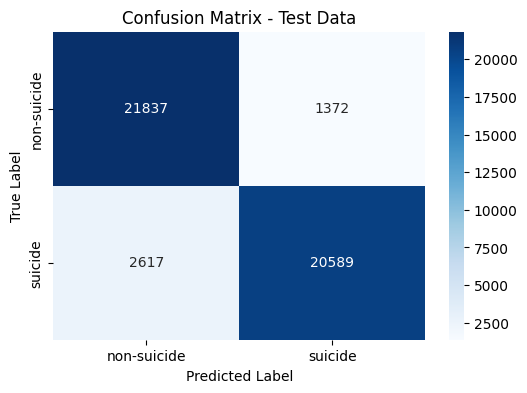

5802/5802 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step
TRAINING DATA CLASSIFICATION REPORT 

              precision    recall  f1-score   support

 non-suicide       0.91      0.94      0.92     92828
     suicide       0.94      0.91      0.92     92831

    accuracy                           0.92    185659
   macro avg       0.92      0.92      0.92    185659
weighted avg       0.92      0.92      0.92    185659



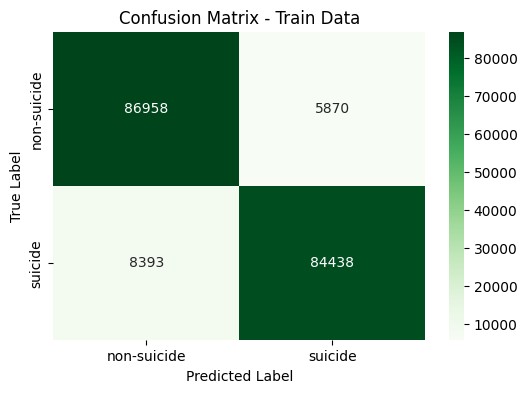

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions for testing data
test_predictions = model.predict(test_text_pad)  # Get probabilities
# Convert probabilities to class labels (0 or 1)
test_pred_classes = (test_predictions > 0.5).astype(int)

print('TESTING DATA CLASSIFICATION REPORT \n')
print(classification_report(test_output, test_pred_classes,
                            target_names=lbl_target.inverse_transform([0, 1])))

# Confusion Matrix for Test Data
conf_matrix_test = confusion_matrix(test_output, test_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=lbl_target.inverse_transform([0, 1]),
            yticklabels=lbl_target.inverse_transform([0, 1]))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Data')
plt.show()


# Generate predictions for training data
train_predictions = model.predict(train_text_pad)  # Get probabilities
# Convert probabilities to class labels (0 or 1)
train_pred_classes = (train_predictions > 0.5).astype(int)

print('TRAINING DATA CLASSIFICATION REPORT \n')
print(classification_report(train_output, train_pred_classes,
                            target_names=lbl_target.inverse_transform([0, 1])))

# Confusion Matrix for Train Data
conf_matrix_train = confusion_matrix(train_output, train_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=lbl_target.inverse_transform([0, 1]),
            yticklabels=lbl_target.inverse_transform([0, 1]))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Train Data')
plt.show()


In [38]:
model.save('model.keras')


In [39]:
from tensorflow import keras

model_h5 = keras.models.load_model('my_model.h5')

model_keras = keras.models.load_model('model.keras')


In [40]:
from tensorflow import keras
model_h5 = keras.models.load_model('my_model.h5')


In [41]:
twt = ['i am very happy']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=50)

prediction = model.predict(twt)[0][0]
print(prediction)

if(prediction > 0.5):
    print("Potential Suicide Post")
else:
    print("Non Suicide Post")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0.3242924
Non Suicide Post


In [42]:
twt = ['I am not gonna do suicide']
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=50)

prediction = model.predict(twt)[0][0]
print(prediction)

if(prediction > 0.5):
    print("Potential Suicide Post")
else:
    print("Non Suicide Post")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0.82922727
Potential Suicide Post


In [43]:
!pip install lime



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
!pip install neattext


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import numpy as np
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from lime.lime_text import LimeTextExplainer
import neattext.functions as nfx

# Load the saved model (either .h5 or .keras)
# For .h5:
model = load_model("my_model.h5")
# Alternatively, for the native Keras format:
# model = load_model("my_model.keras")

# Load your saved tokenizer
tokenizer = pickle.load(open("tokenizer.pkl", "rb"))

# Define a custom prediction function for LIME
def predict_fn(texts):
    """
    Preprocess the input texts and return a probability array for each class.
    Returns:
      - Column 0: probability of non-suicide (1 - probability)
      - Column 1: probability of suicide (probability)
    """
    # Apply cleaning similar to training: lower case, remove special characters and stopwords
    cleaned_texts = [
        nfx.remove_stopwords(nfx.remove_special_characters(text.lower()))
        for text in texts
    ]
    # Convert texts to sequences using the loaded tokenizer
    sequences = tokenizer.texts_to_sequences(cleaned_texts)
    # Pad sequences to the same maxlen used during training (e.g., 40)
    padded = pad_sequences(sequences, maxlen=40)
    # Predict using the loaded model
    preds = model.predict(padded)
    # Construct two-column probabilities: first column for non-suicide, second for suicide
    return np.hstack((1 - preds, preds))

# Create a LIME Text Explainer instance with your class names
explainer = LimeTextExplainer(class_names=['non-suicide', 'suicide'])

# Choose a sample text to explain
sample_text = "Through these past years thoughts of suicide, fear, anxiety I’m so close to my limit"

# Generate explanation using the custom prediction function
exp = explainer.explain_instance(sample_text, predict_fn, num_features=10)

# Or print a simple text explanation
print(exp.as_list())


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[(np.str_('suicide'), 0.48968870591274033), (np.str_('limit'), -0.12718147606022728), (np.str_('fear'), -0.09087525860076016), (np.str_('thoughts'), 0.05044462369244805), (np.str_('I'), -0.04936208156396694), (np.str_('m'), -0.046504816694626194), (np.str_('anxiety'), -0.04565264772357575), (np.str_('years'), 0.020521079983635764), (np.str_('these'), -0.002906809575048865), (np.str_('Through'), 0.002258775119888844)]


In [46]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [47]:
import numpy as np
import pickle
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from lime.lime_text import LimeTextExplainer
import neattext.functions as nfx

# Load the saved model (either .h5 or .keras)
# For .h5:
model = load_model("my_model.h5")
# Alternatively, for the native Keras format:
# model = load_model("my_model.keras")

# Load your saved tokenizer
tokenizer = pickle.load(open("tokenizer.pkl", "rb"))

# Define a custom prediction function for LIME
def predict_fn(texts):
    """
    Preprocess the input texts and return a probability array for each class.
    Returns:
      - Column 0: probability of non-suicide (1 - probability)
      - Column 1: probability of suicide (probability)
    """
    # Apply cleaning similar to training: lower case, remove special characters and stopwords
    cleaned_texts = [
        nfx.remove_stopwords(nfx.remove_special_characters(text.lower()))
        for text in texts
    ]
    # Convert texts to sequences using the loaded tokenizer
    sequences = tokenizer.texts_to_sequences(cleaned_texts)
    # Pad sequences to the same maxlen used during training (e.g., 40)
    padded = pad_sequences(sequences, maxlen=40)
    # Predict using the loaded model
    preds = model.predict(padded)
    # Construct two-column probabilities: first column for non-suicide, second for suicide
    return np.hstack((1 - preds, preds))

# Create a LIME Text Explainer instance with your class names
explainer = LimeTextExplainer(class_names=['non-suicide', 'suicide'])

# Choose a sample text to explain
sample_text = "Through these past years thoughts of suicide, fear, anxiety I’m so close to my limit"

# Generate explanation using the custom prediction function
exp = explainer.explain_instance(sample_text, predict_fn, num_features=10)

# Or print a simple text explanation
print(exp.as_list())


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
[(np.str_('suicide'), 0.4933299566808603), (np.str_('limit'), -0.12610699558186866), (np.str_('fear'), -0.09374303501184414), (np.str_('thoughts'), 0.05425810866258142), (np.str_('I'), -0.049985537134669675), (np.str_('m'), -0.04941564568746201), (np.str_('anxiety'), -0.04480405235820553), (np.str_('years'), 0.017833297809565378), (np.str_('close'), 0.00647546927699428), (np.str_('of'), -0.0051031956233373865)]


In [48]:
texts = dataset['text'].tolist()  # replace 'text' with your actual column name


In [49]:
def predict_fn(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=40)
    preds = model.predict(padded)  # shape: (N, 1)
    return np.hstack([1 - preds, preds])  # shape: (N, 2)


In [50]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 300)        │    81,560,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 40, 20)         │        25,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 20)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,592,015 (311.25 MB)

 Trainable params: 31,313 (122.32 KB)

 Non-trainable params: 81,560,700 (311.13 MB)

 Optimizer params: 2 (12.00 B)

In [51]:
model = load_model("my_model.h5")

In [52]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 40, 300)        │    81,560,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 40, 20)         │        25,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 20)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,592,015 (311.25 MB)

 Trainable params: 31,313 (122.32 KB)

 Non-trainable params: 81,560,700 (311.13 MB)

 Optimizer params: 2 (12.00 B)

In [53]:
twt = ['Through these past years thoughts of suicide, fear, anxiety I’m so close to my limit']
twt = token_form.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=40)

prediction = model_form.predict(twt)[0][0]
print(prediction)

if(prediction > 0.5):
    print("Potential Suicide Post")
elif (prediction == 1):
    print("Non Suicide Post")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
0.82682747
Potential Suicide Post


In [54]:
!pip install transformers
!pip install tf-keras
!pip install torch


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"

import torch

from transformers import pipeline

# Explicit model and revision for production use
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
    revision="714eb0f"
)

text = "I dont want to suicide!"
result = sentiment_pipeline(text)

print(result)



Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9907547831535339}]


In [56]:
from transformers import pipeline

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

def get_sentiment(text):
    result = sentiment_pipeline(text)[0]
    label = result['label']  # 'POSITIVE' or 'NEGATIVE'
    score = result['score']
    return label, score


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [57]:
def final_prediction(text, model):
    # Step 1: Get model prediction
    model_score = model.predict(text)  # Assuming this gives you a float or a label

    # Step 2: Get sentiment
    sentiment_label, sentiment_score = get_sentiment(text)

    # Step 3: Combine logic (customize as needed)
    if sentiment_label == "POSITIVE":
        final_result = "Not suicidal"
    elif sentiment_label == "NEGATIVE":
        if model_score > 0.7:
            final_result = "Potential suicide"
        else:
            final_result = "Low risk"
    else:
        final_result = "Neutral"

    return final_result


In [58]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
from transformers import pipeline

# Load your Keras model
model = load_model('my_model.h5')

# Load your tokenizer (adjust path as needed)
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Preprocessing: convert text to padded sequence
def preprocess(text, tokenizer, max_len=100):
    seq = tokenizer.texts_to_sequences([text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_len)
    return padded

# Sentiment analyzer
def get_sentiment(text):
    result = sentiment_pipeline(text)[0]
    label = result['label']  # 'POSITIVE' or 'NEGATIVE'
    score = result['score']
    return label, score

# Final combined prediction logic
def final_prediction(text, model, tokenizer):
    # Get sentiment
    sentiment_label, sentiment_score = get_sentiment(text)

    # Get model prediction
    processed = preprocess(text, tokenizer)
    model_score = model.predict(processed)[0][0]

    # Combine logic
    if sentiment_label == "POSITIVE":
        return "Not suicidal"
    elif sentiment_label == "NEGATIVE":
        if model_score > 0.7:
            return "Potential suicide"
        elif model_score > 0.4:
            return "Low risk"
        else:
            return "Not suicidal"
    else:
        return "Neutral/Unknown"




No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [ ]:
model.save("new.h5")

NameError: name 'model' is not defined